In [27]:
# Core modules
import os
from io import StringIO
from typing import Callable, List, Dict, Any, Tuple
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np

# Data retrieval
import yfinance as yf

# Plotting modules
import matplotlib.pyplot as plt
import plotly.express as px
import hyperopt.plotting as hplt

# Sklearn ML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator

# Keras DL
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Hyperparameter optimisation
from hyperopt import STATUS_OK, fmin, tpe, Trials, hp
from functools import partial

# Cloud services
from azureml.core import Workspace
from azure.storage.blob import BlobServiceClient
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# Machine learning tracking
import mlflow
import mlflow.keras
import mlflow.sklearn


In [2]:
# downloading data
data = yf.download("^FTSE", start="1999-12-01", end="2022-12-01")

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-01,6597.200195,6655.799805,6575.299805,6646.000000,6646.000000,642023000
1999-12-02,6646.000000,6694.200195,6623.000000,6653.700195,6653.700195,946100000
1999-12-03,6653.700195,6772.100098,6652.299805,6742.200195,6742.200195,954355000
1999-12-06,6742.200195,6769.399902,6657.100098,6694.000000,6694.000000,640360000
1999-12-07,6694.000000,6728.899902,6659.700195,6660.899902,6660.899902,729797000
1999-12-08,6660.899902,6660.899902,6609.500000,6619.399902,6619.399902,916311000
1999-12-09,6619.399902,6688.000000,6619.399902,6680.799805,6680.799805,734306000
1999-12-10,6680.799805,6740.100098,6659.700195,6739.500000,6739.500000,866866000
1999-12-13,6739.500000,6769.700195,6710.700195,6710.700195,6710.700195,610591000


In [4]:
print(data.isnull().sum())
print(data.eq(0).sum())
print(data.index.diff().value_counts().sort_index())


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date
1 days    4590
2 days      11
3 days    1084
4 days      79
5 days      44
Name: count, dtype: int64


In [5]:
fig = px.line(data, x=data.index, y='Adj Close')
fig.update_layout(title={'text': 'Closing price over time', 'x': 0.5})
fig.show()

In [7]:
class KerasLogger:

    def __init__(self, run_name: str):
        self.run_name = run_name

    def __call__(self, func: Callable):

        def wrapper(*args, **kwargs):
            with mlflow.start_run(run_name=self.run_name):
                
                mlflow.keras.autolog()
                model, y_test, y_pred, losses = func(*args, **kwargs)

                metrics = self.get_metrics(y_pred, y_test)
                mlflow.log_metrics(metrics)

                mlflow.keras.log_model(model, artifact_path="models")

                lossplt = self.plot_true_value_vs_prediction(y_pred, y_test)
                mlflow.log_figure(lossplt, "true_value_vs_prediction.png")

                epochplt = self.plot_loss_over_epoch(losses)
                mlflow.log_figure(epochplt, "loss_over_epochs.png")

                return model, y_test, y_pred, losses
        
        return wrapper

        
    @staticmethod
    def plot_true_value_vs_prediction(pred: np.ndarray, test: np.ndarray) -> plt.figure:
        fig, ax = plt.subplots()
        ax.plot(test, label='True Value')
        ax.plot(pred, label='LSTM Value')
        ax.set_title('Prediction by LSTM')
        ax.set_xlabel('Time Scale')
        ax.set_ylabel('Scaled USD')
        ax.legend()
        return fig

    @staticmethod
    def plot_loss_over_epoch(losses: List[float]) -> plt.figure:
        fig, ax = plt.subplots()
        ax.plot(losses)
        ax.set_title('Model Loss Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        return fig
    
    @staticmethod
    def get_metrics(pred: np.ndarray, test: np.ndarray) -> Dict[str, float]:
        mse = mean_squared_error(test, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, pred)
        r2 = r2_score(test, pred)
        msle = mean_squared_log_error(test, pred)
        medae = median_absolute_error(test, pred)
        return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "msle": msle, "medae": medae}

In [11]:
## Building LSTM mode
@KerasLogger(run_name="aalstm")
def train_model(df: pd.DataFrame,
                test_size: int = 10,
                loss: str = 'mean_squared_error',
                activation: str = 'relu',
                optimiser: str = 'adam',
                n_epoch: int = 100,
                batch_size: int = 8,
                verbose: int = 1) -> Tuple[Sequential, np.ndarray, np.ndarray, List[float]]:

    # defome featires, target
    X, y = df.drop('Adj Close', axis=1), data[['Adj Close']]

    # svale features
    X_scaled = MinMaxScaler().fit_transform(X)
    X = pd.DataFrame(data=X_scaled, columns=X.columns, index=X.index)

    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X.shape[1]), activation=activation, return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss=loss, optimizer=optimiser)

    n_split = 100 // test_size - 1
    timesplit = TimeSeriesSplit(n_splits=n_split)

    losses = []
    for i, (train_idx, test_idx) in enumerate(timesplit.split(X)):
        print(f"\n\n---Training model batch {i+1} out of {n_split}---")
        X_train = X[:len(train_idx)]
        X_test = X[len(train_idx): (len(train_idx)+len(test_idx))]
        y_train = y[:len(train_idx)].values.ravel()
        y_test = y[len(train_idx): (len(train_idx)+len(test_idx))].values.ravel()

        print(len(X_train))
        print(len(X_test))
        print(len(X))

        # reshapiong
        X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
        hist = lstm.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size, verbose=verbose)
        losses.extend(hist.history['loss'])
    
    X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
    y_pred = lstm.predict(X_test)
    return lstm, y_test, y_pred, losses

In [13]:
mlflow.set_experiment(experiment_name="demo3")

2024/01/15 16:20:53 INFO mlflow.tracking.fluent: Experiment with name 'demo3' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/a913788/repos/ftsedemo/mlruns/842823595892781680', creation_time=1705335653397, experiment_id='842823595892781680', last_update_time=1705335653397, lifecycle_stage='active', name='demo3', tags={}>



---Training model batch 1 out of 4---
1165
1161
5809
Epoch 1/5
  1/146 [..............................] - ETA: 2:53 - loss: 27052468.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0030s). Check your callbacks.


146/146 [==============================] - 1s 2ms/step - loss: 26809906.0000
Epoch 2/5
146/146 [==============================] - 0s 2ms/step - loss: 26767634.0000
Epoch 3/5
146/146 [==============================] - 0s 2ms/step - loss: 26649896.0000
Epoch 4/5
146/146 [==============================] - 0s 2ms/step - loss: 26459302.0000
Epoch 5/5
1/1 [==============================] - 0s 120ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpycng9xba\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpycng9xba\model\data\model\assets




---Training model batch 2 out of 4---
2326
1161
5809
Epoch 1/5
  1/291 [..............................] - ETA: 8s - loss: 28728640.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.0039s). Check your callbacks.


291/291 [==============================] - 1s 3ms/step - loss: 27887596.0000
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 27048272.0000
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 26101158.0000
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 25058244.0000
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmp1ok_sxzk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmp1ok_sxzk\model\data\model\assets




---Training model batch 3 out of 4---
3487
1161
5809
Epoch 1/5
  1/436 [..............................] - ETA: 7s - loss: 24116860.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.0025s). Check your callbacks.


436/436 [==============================] - 1s 2ms/step - loss: 23043030.0000
Epoch 2/5
436/436 [==============================] - 1s 2ms/step - loss: 21086112.0000
Epoch 3/5
436/436 [==============================] - 1s 2ms/step - loss: 19061270.0000
Epoch 4/5
436/436 [==============================] - 1s 2ms/step - loss: 17006874.0000
Epoch 5/5
1/1 [==============================] - 0s 18ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmptkgoglr0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmptkgoglr0\model\data\model\assets




---Training model batch 4 out of 4---
4648
1161
5809
Epoch 1/5
  1/581 [..............................] - ETA: 24s - loss: 17111590.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_train_batch_end` time: 0.0061s). Check your callbacks.


581/581 [==============================] - 2s 4ms/step - loss: 13731490.0000
Epoch 2/5
581/581 [==============================] - 2s 3ms/step - loss: 10528165.0000
Epoch 3/5
581/581 [==============================] - 1s 2ms/step - loss: 7759345.0000
Epoch 4/5
581/581 [==============================] - 1s 1ms/step - loss: 5427046.0000
Epoch 5/5
1/1 [==============================] - 0s 20ms/step


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpduldr_fd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpduldr_fd\model\data\model\assets


37/37 [==============================] - 0s 1ms/step


2024/01/15 16:21:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpzb3jb84k\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\a913788\AppData\Local\Temp\tmpzb3jb84k\model\data\model\assets


(<keras.engine.sequential.Sequential at 0x1c25a8b19d0>,
 array([7502.20019531, 7509.29980469, 7520.39990234, ..., 7474.        ,
        7512.        , 7573.10009766]),
 array([[5804.836 ],
        [5923.088 ],
        [5817.7646],
        ...,
        [5787.9053],
        [5835.4   ],
        [6068.907 ]], dtype=float32),
 [26809906.0,
  26767634.0,
  26649896.0,
  26459302.0,
  26213190.0,
  27887596.0,
  27048272.0,
  26101158.0,
  25058244.0,
  23933590.0,
  23043030.0,
  21086112.0,
  19061270.0,
  17006874.0,
  14939935.0,
  13731490.0,
  10528165.0,
  7759345.0,
  5427046.0,
  3547576.0])

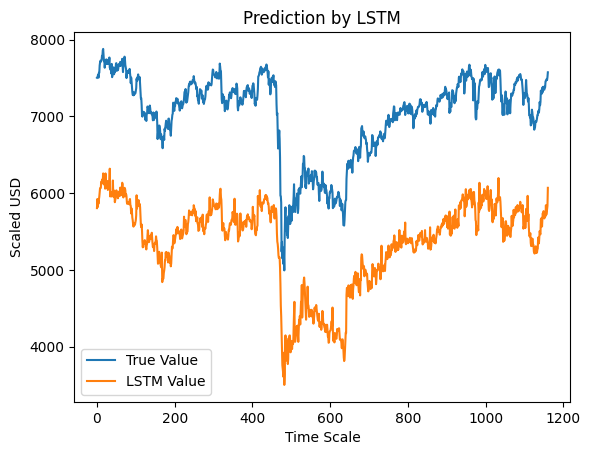

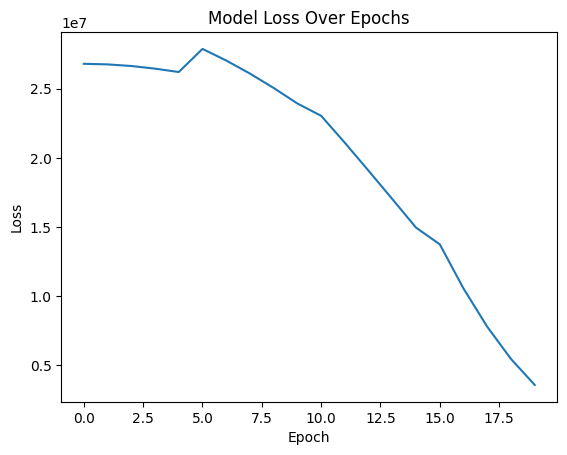

In [14]:
train_model(data, n_epoch=5, test_size=25)

In [15]:
def train_model(hyperparams: Dict[str, Any],
                X_train: pd.DataFrame,
                X_test: pd.DataFrame,
                y_train: pd.Series,
                y_test: pd.Series,
                model: BaseEstimator,
                dtypes: Dict[str, Callable]) -> Dict[str, Any]:
    
    # map datatypes
    for k, v in hyperparams.items():
        if k in dtypes.keys():
            hyperparams[k] = dtypes[k](v)
    
    model = model(**hyperparams)
    hypervals = '_'.join([f'{key}: {value}' for key, value in hyperparams.items()])
    run_name = f"{type(model).__name__}_{hypervals}"
    with mlflow.start_run(nested=True, run_name=run_name) as child_run:
        
        mlflow.sklearn.autolog()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        msle = mean_squared_log_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)

        mlflow.log_metrics({"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "msle": msle, "medae": medae})
    
        return {'status': STATUS_OK, 'loss': mse, "attachments": {"run_id": child_run.info.run_id}}


In [16]:
from dataclasses import dataclass

@dataclass(frozen=True)
class ChildRunData:
    params: Dict[str, Any]
    metrics: Dict[str, float]
    model: BaseEstimator
    run_id: str
    run_name: str
    experiment_id: str

    @classmethod
    def get(cls, run_id):
        client = mlflow.tracking.MlflowClient()
        run = mlflow.get_run(run_id)

        metrics = run.data.metrics
        params = run.data.params
        models = client.download_artifacts(run_id, path="model")
        run_name = run.info.run_name
        experiment_id = run.info.experiment_id

        return cls(params, metrics, models, run_id, run_name, experiment_id)

In [17]:



def search(hyperparam_space: Dict[str, Any],
           df: pd.DataFrame,
           target: str,
           model: BaseEstimator,
           dtypes: Dict[str, Callable],
           max_evals: int = 100) -> Tuple[Trials, Dict[str, Any]]:

    X, y = df.drop(target, axis=1), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    with mlflow.start_run(nested=False, run_name=model.__name__):
        trials = Trials()
        best_params = fmin(
            fn=partial(
                train_model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, model=model, dtypes=dtypes
                ),
            space=hyperparam_space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=max_evals
        )

        best_run_id = trials.trial_attachments(trials.best_trial)["run_id"]
        best_run_data = ChildRunData.get(best_run_id)

        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_params({f"best_{p}": v for p, v in best_params.items()})
        mlflow.log_metric("best_mse", trials.best_trial["result"]["loss"])
        mlflow.log_metrics(best_run_data.metrics)
        mlflow.log_artifacts(local_dir=best_run_data.model, artifact_path="model")

        fig = plt.figure()
        fig.add_subplot()
        hplt.main_plot_histogram(trials, do_show=False)
        mlflow.log_figure(fig, "loss_histogram.png")

        return trials, best_params


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/01/15 16:27:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:27:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 10%|█         | 1/10 [00:05<00:45,  5.09s/trial, best loss: 1050559.1212967033]

2024/01/15 16:27:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:27:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 20%|██        | 2/10 [00:09<00:38,  4.84s/trial, best loss: 1050553.9395558895]

2024/01/15 16:27:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 30%|███       | 3/10 [00:46<02:14, 19.27s/trial, best loss: 67157.15777966086] 

2024/01/15 16:28:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 40%|████      | 4/10 [00:49<01:17, 12.97s/trial, best loss: 67157.15777966086]

2024/01/15 16:28:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 50%|█████     | 5/10 [00:53<00:48,  9.77s/trial, best loss: 67157.15777966086]

2024/01/15 16:28:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 60%|██████    | 6/10 [00:57<00:31,  7.82s/trial, best loss: 67157.15777966086]

2024/01/15 16:28:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 70%|███████   | 7/10 [01:03<00:21,  7.21s/trial, best loss: 67157.15777966086]

2024/01/15 16:28:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 80%|████████  | 8/10 [01:07<00:12,  6.05s/trial, best loss: 67157.15777966086]

2024/01/15 16:28:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 90%|█████████ | 9/10 [01:13<00:06,  6.07s/trial, best loss: 67157.15777966086]

2024/01/15 16:28:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



100%|██████████| 10/10 [01:21<00:00,  8.12s/trial, best loss: 67157.15777966086]
Showing Histogram of 10 jobs
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/01/15 16:28:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:28:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 10%|█         | 1/10 [00:04<00:43,  4.86s/trial, best loss: 76907.25342094756]

2024/01/15 16:28:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 20%|██        | 2/10 [00:08<00:34,  4.26s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 30%|███       | 3/10 [00:13<00:30,  4.41s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 40%|████      | 4/10 [00:19<00:31,  5.19s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 50%|█████     | 5/10 [00:22<00:22,  4.51s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 60%|██████    | 6/10 [00:26<00:16,  4.01s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 70%|███████   | 7/10 [00:29<00:11,  3.72s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 80%|████████  | 8/10 [00:32<00:07,  3.53s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



 90%|█████████ | 9/10 [00:35<00:03,  3.37s/trial, best loss: 76907.25342094756]

2024/01/15 16:29:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."

2024/01/15 16:29:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\a913788\AppData\Local\pypoetry\Cache\virtualenvs\ftsedemo-Ew-uKU1O-py3.11\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."



100%|██████████| 10/10 [00:38<00:00,  3.83s/trial, best loss: 76907.25342094756]
Showing Histogram of 10 jobs


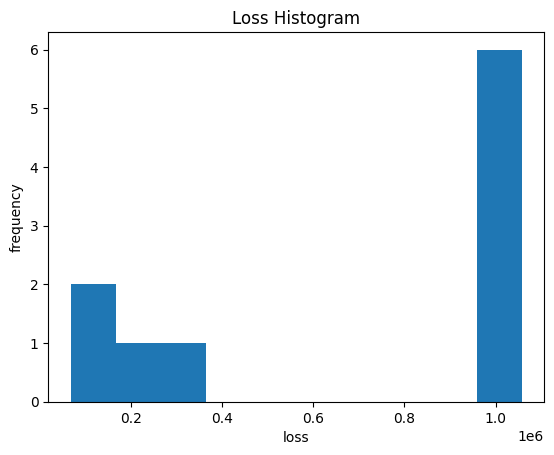

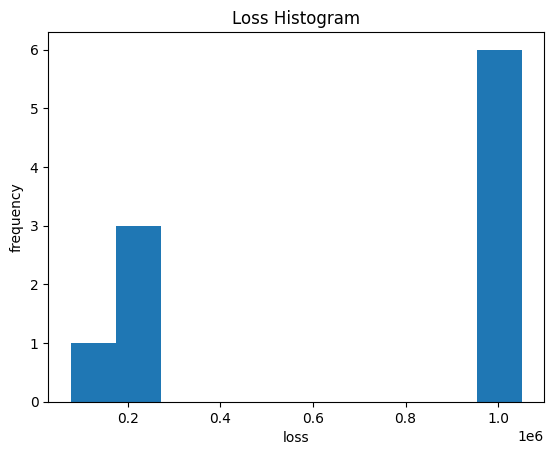

In [18]:


rfspace = {
    "n_estimators": hp.uniform("n_estimators", 200, 1000),
    "max_depth": hp.quniform("max_depth", 10, 1200, 10),
    "min_samples_split": hp.uniform("min_samples_split", 0.1, 1.0),
    "min_samples_leaf": hp.uniform("min_samples_leaf", 0.1, 0.5),
    "max_features": hp.choice("max_features", options=[None, 'sqrt', 'log2']),
    "criterion": hp.choice("criterion", ['squared_error', 'poisson', 'absolute_error', 'friedman_mse'])
}


gbmspace = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', [None, hp.quniform('max_depth_val', 3, 10, 1)]),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}


rfdtypes = {"max_depth": lambda x: int(x), "n_estimators": lambda x: int(x)}
gbmdtypes = {"max_depth": lambda x: int(x) if x is not None else x, "n_estimators": lambda x: int(x)}

data = data.astype(float)

models = [RandomForestRegressor, GradientBoostingRegressor]
for model, grid, dtype in zip(models, [rfspace, gbmspace], [rfdtypes, gbmdtypes]):
    search(grid, data, 'Adj Close', model, dtype, max_evals=10)


In [22]:
last_run = mlflow.last_active_run()
child_runs = mlflow.search_runs(
    filter_string=f"tags.mlflow.parentRunId='{last_run.info.run_id}'"
)
with pd.option_context("display.max_columns", None):
    print(child_runs.sort_values(by='metrics.mae'))

                             run_id       experiment_id    status  \
9  42c981d2c183455e8293722a56c779e8  842823595892781680  FINISHED   
5  d07e03038da2429297392b44b26284e0  842823595892781680  FINISHED   
6  d737f564a5a94cd4945ef54be3a107dd  842823595892781680  FINISHED   
3  6e83263f27e04664a5c7f257ef6a219e  842823595892781680  FINISHED   
1  e14a20b617444797a1d242e528982b1d  842823595892781680  FINISHED   
0  355c91295468401394144473cfe88a34  842823595892781680  FINISHED   
8  5e36e0ad50364f53a0efcb138a647d00  842823595892781680  FINISHED   
4  97ad1b59ff8d4656b9e3c3c319ec38ac  842823595892781680  FINISHED   
2  a7734f88aa674972b815b52205b3ca11  842823595892781680  FINISHED   
7  38e99a536c6f446d9dd1e73d5a50408d  842823595892781680  FINISHED   

                                        artifact_uri  \
9  file:///c:/Users/a913788/repos/ftsedemo/mlruns...   
5  file:///c:/Users/a913788/repos/ftsedemo/mlruns...   
6  file:///c:/Users/a913788/repos/ftsedemo/mlruns...   
3  file:///c:/Us

In [23]:
workspace = Workspace.from_config()
repr(workspace)

"Workspace.create(name='daadspocs', subscription_id='b501a57e-71d5-4887-b72c-a0c961a0f281', resource_group='uk-environment')"

In [24]:
# creating data store within workspace
load_dotenv(find_dotenv())
connection_string = os.environ.get('AZURE_STORAGE_CONNECTION_STRING')
container = os.environ.get('CONTAINER_NAME')

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container)

main_blob_name = 'ftse100data.csv'

In [25]:
def save_data_to_blob(blob_name: str, df: pd.DataFrame, overwrite: bool = True) -> None:
    container_client.upload_blob(name=blob_name, data=df.to_csv(), overwrite=overwrite)

def read_data_from_blob(blob_name: str) -> pd.DataFrame:
    blob_client = container_client.get_blob_client(blob_name)
    data = blob_client.download_blob().readall().decode('utf-8')
    df = pd.read_csv(StringIO(data), parse_dates=['Date'])
    return df.set_index('Date')

save_data_to_blob(main_blob_name, data)
x = read_data_from_blob(main_blob_name)
x.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-24,7465.200195,7488.100098,7443.500000,7466.600098,7466.600098,4.182861e+08
2022-11-25,7466.600098,7497.200195,7461.799805,7486.700195,7486.700195,5.227197e+08
2022-11-28,7486.700195,7496.799805,7420.000000,7474.000000,7474.000000,6.626226e+08
2022-11-29,7474.000000,7543.100098,7474.000000,7512.000000,7512.000000,7.146852e+08
2022-11-30,7512.000000,7599.299805,7512.000000,7573.100098,7573.100098,1.394738e+09


In [30]:
mlclient = MLClient.from_connection_string(connection_string)

AttributeError: type object 'MLClient' has no attribute 'from_connection_string'